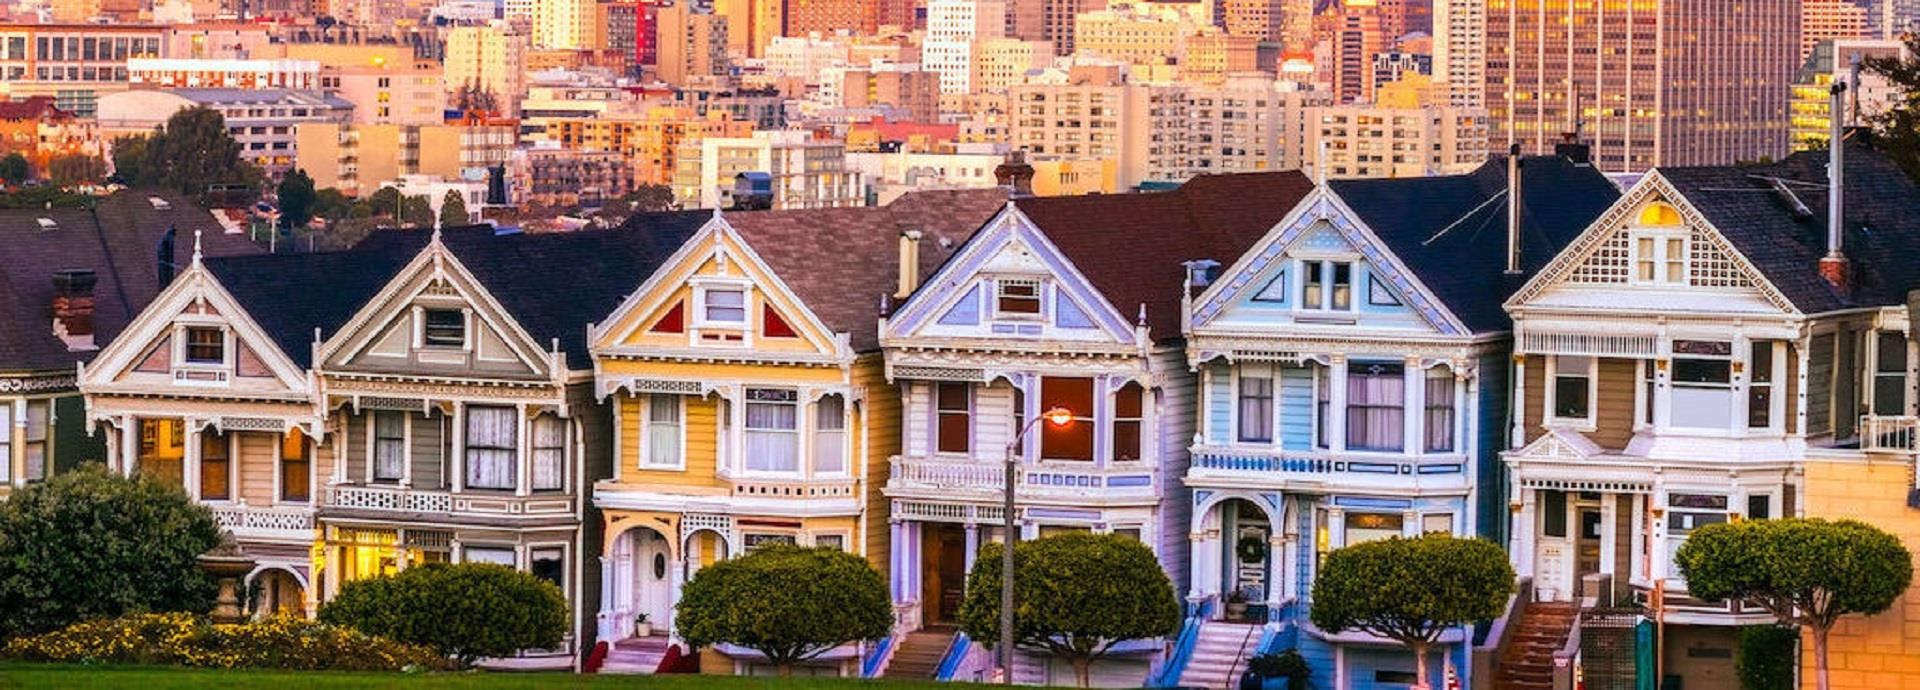

# Zillow Times Series Analysis 
Author: Jennifer Ha
***

## Overview
With their recent successful real estate investment in New York, our client Stellar Property Group seeks to expand their listings in California, which happens to be the other state with the most Fortune 500 company headquarters besides New York. Our client believes the trends and contributing factors that they saw in New York, especially the continued job growth will also positively impact the home values in California. The team is looking for recommendations on top 5 zipcodes to invest in California, and this analysis will also provide them with short-term vs. long-term investment decisions.

## Business Understanding
The goal of this analysis is to identify the top 5 zipcodes for our client to invest in California. The team is not quite familiar with the West Coast real estate market, and therefore, has asked to take risk factor into consideration. The results from this analysis will provide them with the forecast of next 10 year mean house values in the top 5 zipcodes as well as expected ROI in 1 year, 3 years, 5 years, and 10 years. 

## Data
The dataset for this analysis comes from [Zillow Research](https://www.zillow.com/research/data/), which contains the median home sales prices in 14,723 individual zipcodes from April 1996 through April 2018. Each row represents a unique zip code indexed with RegioinID, and contains location info and median housing sales prices for each month.

## Data Cleaning

Below, we will clean up our data to include California zipcodes only, and reshaping it form wide to long format.

In [1]:
# Import all libraries & packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
from functions import *

import warnings
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')

from math import sqrt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error

/Users/jenniferha/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Import data into a dataframe and preview 
df = pd.read_csv('data/zillow_data.csv')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
#Check for duplicates
df.RegionID.duplicated().sum()

0

Our client is interested in California only so let's remove data from all other states.

In [4]:
# Keep CA state only
df_ca = df.loc[df['State']=='CA'].reset_index()

# Drop unnecessary columns
df_ca.drop(['index', 'RegionID', 'SizeRank'], axis=1, inplace=True)

df_ca.info()
df_ca.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1224 entries, 0 to 1223
Columns: 270 entries, RegionName to 2018-04
dtypes: float64(219), int64(47), object(4)
memory usage: 2.5+ MB


,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,94109,San Francisco,CA,San Francisco,San Francisco,766000.0,771100.0,776500.0,781900.0,787300.0,...,3767700,3763900,3775000,3799700,3793900,3778700,3770800,3763100,3779800,3813500
1,90250,Hawthorne,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,152500.0,152600.0,152600.0,152600.0,152600.0,...,579300,585700,590900,594700,598500,601300,602800,606100,612400,616200
2,94565,Pittsburg,CA,San Francisco,Contra Costa,139200.0,138300.0,137500.0,136600.0,135600.0,...,394900,398400,401600,405400,408600,410900,413700,417900,424300,430100
3,90046,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,340600.0,341700.0,343000.0,344400.0,346100.0,...,1839800,1861100,1888600,1903900,1907500,1922100,1952400,1974500,1975900,1966900
4,94501,Alameda,CA,San Francisco,Alameda,222400.0,222300.0,222400.0,222600.0,223000.0,...,965100,975000,987800,1000000,1009900,1021000,1032400,1042000,1053000,1059700


In [5]:
# Rename 'RegionName' to 'Zipcode'
df_ca = df_ca.rename(columns={'RegionName': 'ZipCode'})

df_ca.head()

,ZipCode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,94109,San Francisco,CA,San Francisco,San Francisco,766000.0,771100.0,776500.0,781900.0,787300.0,...,3767700,3763900,3775000,3799700,3793900,3778700,3770800,3763100,3779800,3813500
1,90250,Hawthorne,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,152500.0,152600.0,152600.0,152600.0,152600.0,...,579300,585700,590900,594700,598500,601300,602800,606100,612400,616200
2,94565,Pittsburg,CA,San Francisco,Contra Costa,139200.0,138300.0,137500.0,136600.0,135600.0,...,394900,398400,401600,405400,408600,410900,413700,417900,424300,430100
3,90046,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,340600.0,341700.0,343000.0,344400.0,346100.0,...,1839800,1861100,1888600,1903900,1907500,1922100,1952400,1974500,1975900,1966900
4,94501,Alameda,CA,San Francisco,Alameda,222400.0,222300.0,222400.0,222600.0,223000.0,...,965100,975000,987800,1000000,1009900,1021000,1032400,1042000,1053000,1059700


In [6]:
#Code from Project 4 Start Notebook to Reshape from wide to long format
def melt_data(df):
    melted = pd.melt(df, 
                     id_vars=['ZipCode', 'City', 'State', 'Metro', 'CountyName'], 
                     var_name='Date')
    melted['Date'] = pd.to_datetime(melted['Date'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [7]:
melted_df = melt_data(df_ca)
melted_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318744 entries, 0 to 324359
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   ZipCode     318744 non-null  int64         
 1   City        318744 non-null  object        
 2   State       318744 non-null  object        
 3   Metro       308142 non-null  object        
 4   CountyName  318744 non-null  object        
 5   Date        318744 non-null  datetime64[ns]
 6   value       318744 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 19.5+ MB


In [8]:
#Convert data type to string for ZipCode column
melted_df['ZipCode'] = melted_df['ZipCode'].astype(str)

# Make sure the data type of the 'Date' column is datetime
melted_df['Date'] = pd.to_datetime(melted_df['Date'], format='%Y/%m')

# Set the 'Date' column as index
melted_df.set_index('Date', inplace=True)

melted_df.info
melted_df.head()

,ZipCode,City,State,Metro,CountyName,value
Date,,,,,,
1996-04-01,94109,San Francisco,CA,San Francisco,San Francisco,766000.0
1996-04-01,90250,Hawthorne,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,152500.0
1996-04-01,94565,Pittsburg,CA,San Francisco,Contra Costa,139200.0
1996-04-01,90046,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,340600.0
1996-04-01,94501,Alameda,CA,San Francisco,Alameda,222400.0


## Exploratory Data Analysis (EDA)
Let's get a better understanding of the data we are working with. We will also indetify top 10 zipcodes for analysis before making the decision on final top 5.

In [9]:
print('Average CA home value' ,round(melted_df['value'].mean()))

Average CA home value 457429


### Average Home Value by Month and Year

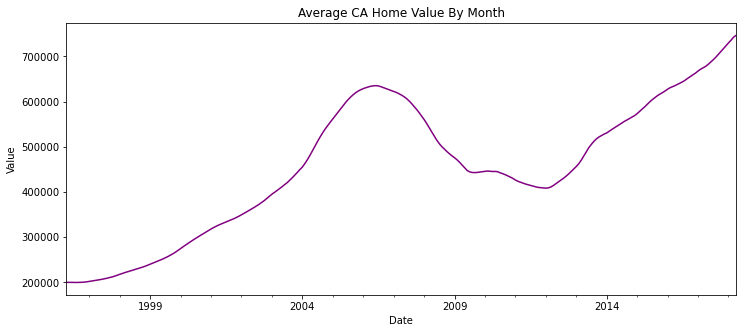

In [10]:
# Resample data by month
month_data = melted_df['value'].resample('MS').mean()
month_data = month_data.fillna(month_data.bfill())
month_data.plot(figsize=(12,5), color='purple')
plt.title('Average CA Home Value By Month')
plt.ylabel('Value')
plt.show()

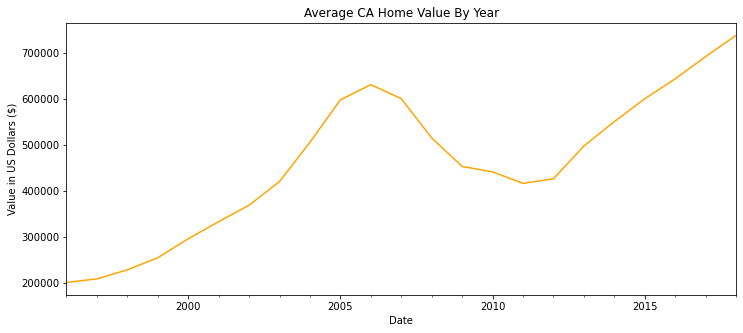

In [11]:
# Resample data by month
yr_data = melted_df['value'].resample('A').mean()
yr_data.plot.line(figsize=(12,5), color='orange')
plt.title('Average CA Home Value By Year')
plt.ylabel('Value in US Dollars ($)')
plt.show()

The trend in monthly and yearly average home value is very similar. Both are generally upward trending but showing a dip in year 2007-2012.

### Top 10 Metro & County (mean value)

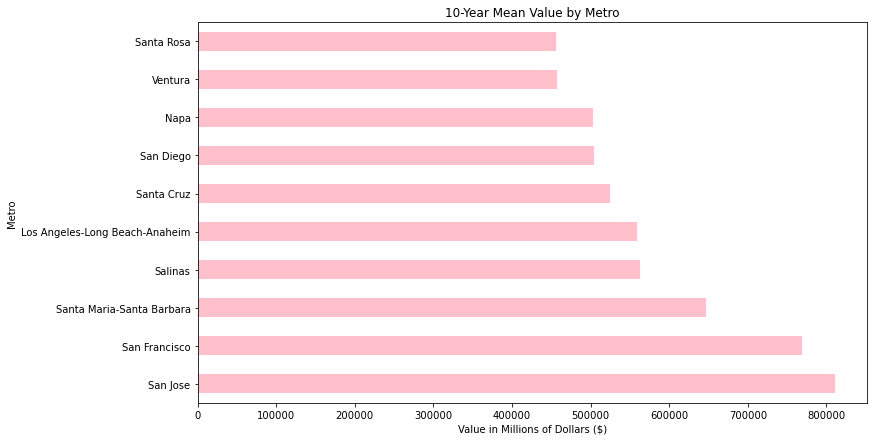

In [12]:
#Get Mean Home Value by metro
metro = melted_df.groupby('Metro')
metro = metro.value.mean()
metro = metro.sort_values(ascending=False).head(10)

#Plot Mean HOme Value by Metro
metro.plot.barh(figsize = (12,7),color='pink')
plt.title('10-Year Mean Value by Metro')
plt.xlabel('Value in Millions of Dollars ($)')
plt.show()

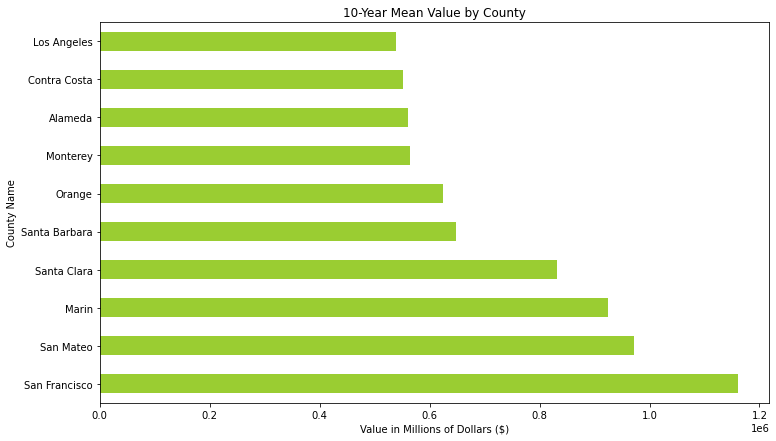

In [13]:
#Get Mean Home Value by County
county = melted_df.groupby('CountyName')
county = county.value.mean()
county = county.sort_values(ascending=False).head(10)

#Plot Mean Home Value by County
county.plot.barh(figsize = (12,7),color='yellowgreen')
plt.title('10-Year Mean Value by County')
plt.xlabel('Value in Millions of Dollars ($)')
plt.ylabel('County Name')
plt.show()

### Top 10 Zipcode ( mean ROI)
Here I wanted to add some variation and selected data bewteen 30-70 quartiles.

In [14]:
#Calculate average home value in the DataFrame
df_ca['yr_avg']=df_ca.iloc[:,-60:].mean(skipna=True, axis=1)

#Get zipcodes with an average value 2 decile above the median and 2 deciles below.
print(df_ca['yr_avg'].describe(),'\n')

#Calculate the 70% cutoff value (2 decile above).
q_70 = df_ca['yr_avg'].quantile(q=0.70)
print(f'Average Value 70% cutoff value: {round(q_70,2)}')

#Calculate the 30% cutoff value (2 deciles below).
q_30 = df_ca['yr_avg'].quantile(q=0.30)
print(f'Average Value 30% cutoff value: {round(q_30,2)}')

#Get data frame with selected zipcodes.
df_avg = df_ca[(df_ca['yr_avg']<q_70) & (df_ca['yr_avg']>q_30)]
print(f'Amount of zipcodes: {len(df_avg)}')

count    1.224000e+03
mean     6.146968e+05
std      5.553401e+05
min      5.477833e+04
25%      2.826767e+05
50%      4.664775e+05
75%      7.432292e+05
max      5.319428e+06
Name: yr_avg, dtype: float64 

Average Value 70% cutoff value: 654150.17
Average Value 30% cutoff value: 313131.83
Amount of zipcodes: 490


Per our client's request, we will build risk profile using [coefficient of variation](https://www.investopedia.com/terms/c/coefficientofvariation.asp) and assume above 60 percentile is risky. This is a very commen method used by many investors and analysts in finance to determine the volatility and risk when making investments. The lower the ratio of the standard deviation to mean return, the better risk-return trade-off.

In [15]:
#Calculate historical return on investment
df_avg['ROI'] = (df_avg['yr_avg']/df_avg['1996-04'])-1

#Calculate standard deviation of monthly values
df_avg['std'] = df_avg.loc[:,'1996-04':'2018-04'].std(skipna=True, axis=1)

#Calculate historical mean value
df_avg['mean'] = df_avg.loc[:,'1996-04':'2018-04'].mean(skipna=True, axis=1)

#Calculate coefficient of variation
df_avg['CV'] = df_avg['std']/df_avg['mean']

#Show calculated values
df_avg[['ZipCode','std','mean','ROI','CV','CountyName']].head()

,ZipCode,std,mean,ROI,CV,CountyName
1,90250,138601.533036,365464.150943,2.262240,0.379248,Los Angeles
2,94565,104006.852657,263874.339623,1.334291,0.394153,Contra Costa
7,90044,97293.744047,243829.811321,1.686262,0.399023,Los Angeles
8,90805,108971.123756,281955.471698,1.918213,0.386483,Los Angeles
9,95630,106331.603220,373722.264151,1.513737,0.284520,Sacramento


In [16]:
#Find out the top 10 couties with highest ROI
grp_county = df_avg.groupby('CountyName', group_keys=False).sum()['ROI']
grp_county.sort_values(ascending=False)[:10]

CountyName
Los Angeles       313.935844
San Diego         113.669953
Orange             70.569764
Riverside          41.097313
Ventura            32.937638
Sacramento         32.498056
San Bernardino     31.662873
Alameda            29.279048
Placer             27.415028
Sonoma             26.812512
Name: ROI, dtype: float64

In [17]:
#Top 10 counties with highest ROI before considering risk factor CV
grp_county.sort_values(ascending=False)[:10].keys()

Index(['Los Angeles', 'San Diego', 'Orange', 'Riverside', 'Ventura',
       'Sacramento', 'San Bernardino', 'Alameda', 'Placer', 'Sonoma'],
      dtype='object', name='CountyName')

In [18]:
#Descriptive statistics of coefficients of variance
print(df_avg.CV.describe())

#Define upper limit of CV according to risk profile
thresh_cv = df_avg.CV.quantile(.6)
print(f'\nCV upper limit: {thresh_cv}')

#Get the 10 counties with highest ROIs within the firms risk profile.
df_top10 = df_avg[df_avg['CV']<thresh_cv].sort_values('ROI', axis=0, ascending=False)

#Find out the top 10 couties with highest ROI
grp_county = df_top10.groupby('CountyName').sum()['ROI']
grp_county.sort_values(ascending=False)[:10]

count    490.000000
mean       0.342695
std        0.045802
min        0.062004
25%        0.316948
50%        0.343743
75%        0.367369
max        0.496292
Name: CV, dtype: float64

CV upper limit: 0.35277120068469897


CountyName
San Diego          81.000270
Los Angeles        69.132190
Orange             29.551015
Riverside          28.391854
Placer             27.415028
Sonoma             26.812512
San Luis Obispo    24.860144
Sacramento         24.044008
Ventura            22.830799
Alameda            14.629467
Name: ROI, dtype: float64

In [19]:
top10_county = list(grp_county.sort_values(ascending=False)[:10].index)
top10_county

['San Diego',
 'Los Angeles',
 'Orange',
 'Riverside',
 'Placer',
 'Sonoma',
 'San Luis Obispo',
 'Sacramento',
 'Ventura',
 'Alameda']

In [20]:
df_top10 = df_top10.loc[df_top10['CountyName'].isin(top10_county)]

In [21]:
#Check how many zip code are in each county
df_top10['CountyName'].value_counts()

San Diego          44
Los Angeles        40
Riverside          21
Placer             18
Sacramento         17
Sonoma             16
Orange             14
San Luis Obispo    13
Ventura            13
Alameda             8
Name: CountyName, dtype: int64

In [105]:
#Get city and state names for each zip code
ziplist = []
roi_top10 = {}

for i in top10_county:
    City = df_top10[df_top10['CountyName']==i].City.values[0]
    Metro = df_top10[df_top10['CountyName']==i].Metro.values[0]
    County = df_top10[df_top10['CountyName']==i].CountyName.values[0]
    ZipCode = df_top10[df_top10['CountyName']==i].ZipCode.values[0]
    ROI = (df_top10[df_top10['CountyName']==i].mean()['ROI'])*100
    
    ziplist.append(str(ZipCode))
    
    roi_top10[i] = ROI
    print(f'County: {i}, Average ROI: {ROI} \nCity: {City}, Zipcode: {ZipCode}, Metro: {Metro}\n')

County: San Diego, Average ROI: 184.09152301937232 
City: San Diego, Zipcode: 92101, Metro: San Diego

County: Los Angeles, Average ROI: 181.9268168820959 
City: Monterey Park, Zipcode: 91754, Metro: Los Angeles-Long Beach-Anaheim

County: Orange, Average ROI: 211.07867725013816 
City: Orange, Zipcode: 92866, Metro: Los Angeles-Long Beach-Anaheim

County: Riverside, Average ROI: 135.1993034060613 
City: Norco, Zipcode: 92860, Metro: Riverside

County: Placer, Average ROI: 152.30571218229363 
City: Homewood, Zipcode: 96141, Metro: Sacramento

County: Sonoma, Average ROI: 167.57819905750162 
City: Geyserville, Zipcode: 95441, Metro: Santa Rosa

County: San Luis Obispo, Average ROI: 191.23187948750837 
City: San Luis Obispo, Zipcode: 93405, Metro: San Luis Obispo

County: Sacramento, Average ROI: 141.4353428789623 
City: Sacramento, Zipcode: 95818, Metro: Sacramento

County: Ventura, Average ROI: 175.6215318542781 
City: Ventura, Zipcode: 93003, Metro: Ventura

County: Alameda, Average RO

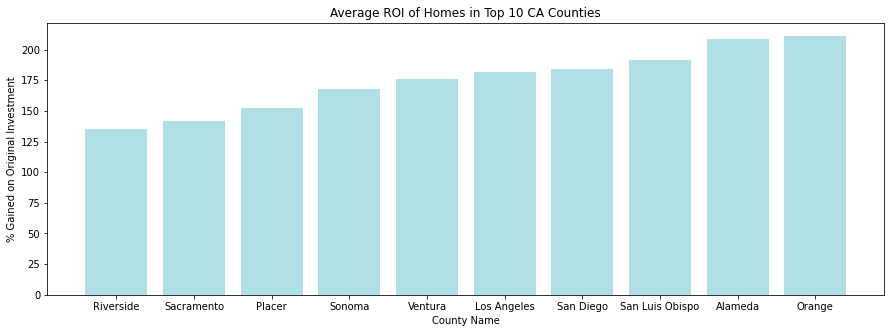

In [106]:
x = dict(sorted(roi_top10.items(), key=lambda item: item[1])).keys()
y = dict(sorted(roi_top10.items(), key=lambda item: item[1])).values()


plt.figure(figsize=(15,5))
plt.bar(x, y, color='powderblue')
plt.title('Average ROI of Homes in Top 10 CA Counties')
plt.xlabel('County Name')
plt.ylabel('% Gained on Original Investment')
plt.show()

Our analysis shows that all top 10 counties saw ROI above 125% since April 1996. Out of those counties, San Luis Obispo, Alameda, and Ornage counties had the highest ROI around 200%.

## Preprocessing

In [24]:
#create a dictionary for each zipcode
ts = {}
for zc in ziplist:
    temp_df = melted_df.groupby('ZipCode').get_group(zc).sort_index()['value']
    ts[zc] = temp_df

In [25]:
ts_df = pd.DataFrame(ts)
ts_df.head()

,92101,91754,92866,92860,96141,95441,93405,95818,93003,94546
Date,,,,,,,,,,
1996-04-01,147000.0,188600.0,173700.0,162900.0,170600.0,223800.0,181000.0,144000.0,182900.0,202100.0
1996-05-01,147400.0,188000.0,173600.0,162200.0,171800.0,222900.0,181700.0,144300.0,182700.0,201600.0
1996-06-01,147700.0,187400.0,173500.0,161500.0,172900.0,221900.0,182500.0,144500.0,182400.0,201100.0
1996-07-01,148100.0,186900.0,173500.0,160800.0,174000.0,220900.0,183300.0,144500.0,182200.0,200600.0
1996-08-01,148500.0,186500.0,173600.0,160200.0,175100.0,220000.0,184300.0,144600.0,182100.0,200200.0


In [26]:
ts_92101 = ts_df[ziplist[0]].copy()

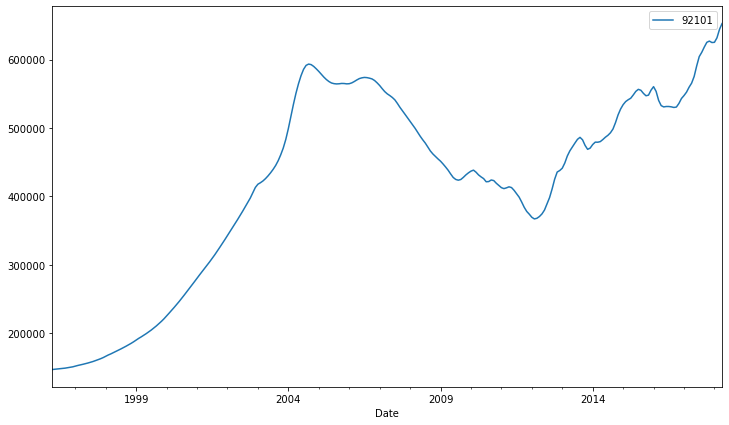

In [27]:
ax = ts_92101.plot(figsize=(12,7))
ax.legend()
plt.show()

### Train-Test Split

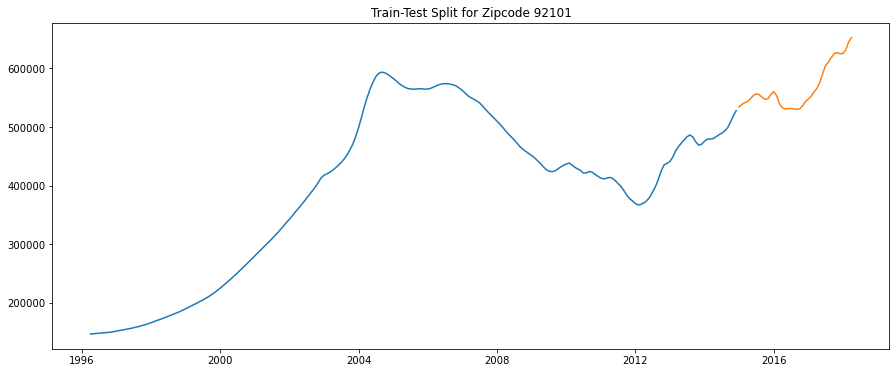

In [28]:
#Find the index to split 15% of the data
train_size = 0.85 
split_idx = round(len(ts_92101)* train_size)
split_idx

##Split
train = ts_92101.iloc[:split_idx]
test = ts_92101.iloc[split_idx:]

# Visualize split
# Taking San Diego as an example
fig,ax = plt.subplots(figsize=(15,6))
ax.plot(train)
ax.plot(test)
ax.set_title('Train-Test Split for Zipcode 92101');

## Model 1: Random Walk Model
For our first iteration, we will try a siple prediction model, Random Walk model. This model can be a baseline model to compare how our more sophisticated models, such as ARIMA and SARIMA models with gridsearch, perform. by evaluating AIC and RMSE.

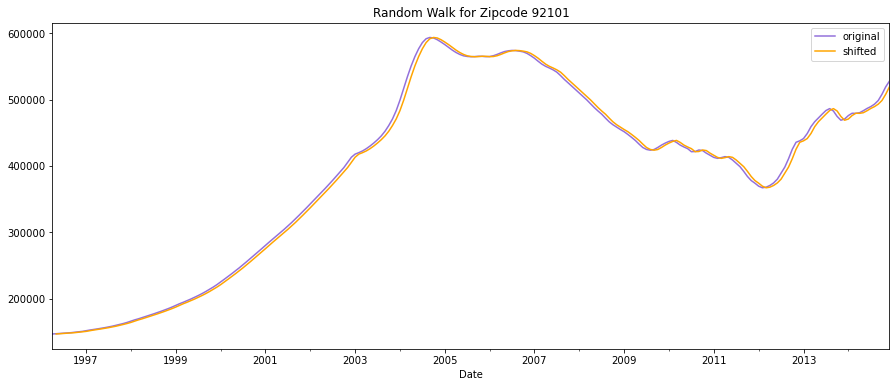

In [29]:
train = ts_92101.iloc[:split_idx]
random_walk = train.shift(1)

fig,ax = plt.subplots(figsize=(15,6))

train[0:270].plot(ax=ax, c='mediumpurple', label='original')
random_walk[0:270].plot(ax=ax, c='orange', label='shifted')
ax.set_title('Random Walk for Zipcode 92101')
ax.legend();

In [30]:
# Calculate Root Mean Squared Error for above data 
residuals = random_walk - train
rmse = mean_squared_error(train[1:], random_walk.dropna())
rmse # use as benchmark for our modeling process 

27141651.785714287

## Model 2: ARIMA Model
Below, I will run some ARIMA models and see if they can perform better than my Random Walk model.

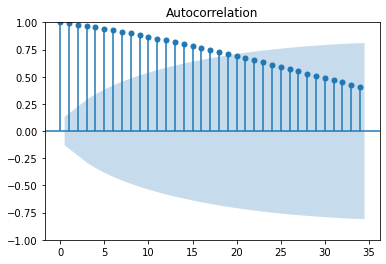

In [31]:
plot_acf(train,lags=34);

The above autocorrelation shows that there is corrletation between lags up about 20 weeks back. Due to the strong correlation with higher order lags, I will check if first difference makes them any better.

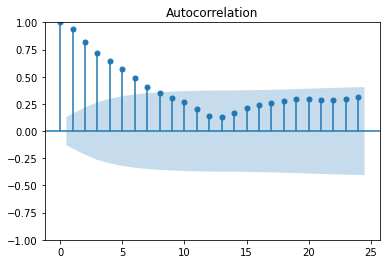

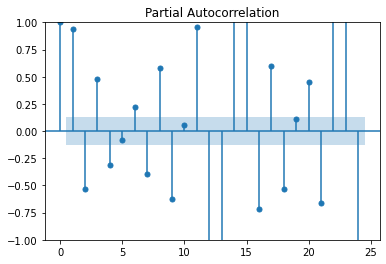

In [32]:
#0,1,0) model results
plot_acf(train.diff().dropna());
plot_pacf(train.diff().dropna());

ACF plot looks better (still not ideal) and tells us that there is a strong correlation with lag around 10. Also, our PACF shows an extremely different result where all lags are statiscally significant. 

Our first model did not do so well, and therefore, we will run more iterations below. We will explore ARIMAX and SARIMAX but I would like to try hand-manually selecting the parameter values based on the result above. Nothing is guaranteed but I'm hoping to see better results.

### Selecting Hyperparameter Values Manually

In [33]:
rmse_arima(train, 1, 1, 1)
aic_arima(train, 1, 1, 1)

10657.237647159529
4378.343678228663


In [34]:
rmse_arima(train, 2, 1, 1)
aic_arima(train, 2, 1, 1)

10817.862709288027
4423.638782519734


In [35]:
rmse_arima(train, 3, 1, 2)
aic_arima(train, 3, 1, 2)

10521.719771336077
5616.351884292737


In [36]:
rmse_arima(train, 5, 1, 5)
aic_arima(train, 5, 1, 5)

10466.847650847345
6010.843198045274


I imangined that this could be a fun excercise but the results are not too promising. The last iteration shows that higher value for p and q parameters returns better results but not ideal. It actually seems all over the place, which leads to the conculsion that we should try running models using `auto_arima()`. We will first run a ARIMAX model and then SARIMAX model.

### Gridsearch

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=3944.941, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=3948.154, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=3943.351, Time=0.08 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=3945.051, Time=0.24 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=3960.481, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=3962.415, Time=0.12 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=3945.190, Time=0.15 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.686 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  225
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -1969.676
Date:                Mon, 01 Nov 2021   AIC                           3943.351
Time:                        12:36:41   BIC                           3950.165
Sample:                             0   HQIC                          3946.102
                                - 225                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0335      0.010      3.394      0.001       0.014       0.053
sigma2      2.722e+06   1.38e+05     19.727      0.000    2.45e+06    2.99e+06
===================================================================================
Ljung-Box (L1) (Q):                  42.82   Jarque-Bera (JB):               252.12
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              46.81   Skew:                            -0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

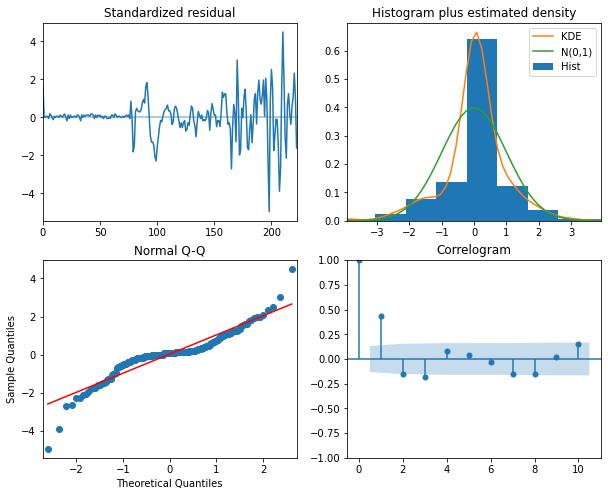

In [37]:
auto_model=auto_arima(y=train,start_p=0,start_q=0, seasonal=True, trace=True)
display(auto_model.summary())
auto_model.plot_diagnostics(figsize=(10,8));

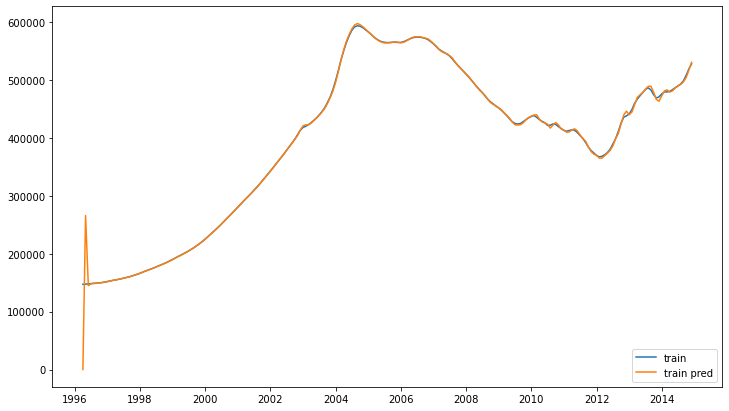

In [38]:
#Plotting training predictions
auto_model = ARIMA(train,order=(0,2,1)).fit()
train_pred = auto_model.predict(typ='levels')

fig,ax=plt.subplots(figsize=(12,7))
ax.plot(train, label='train')
ax.plot(train_pred, label='train pred')
ax.legend(loc='lower right');

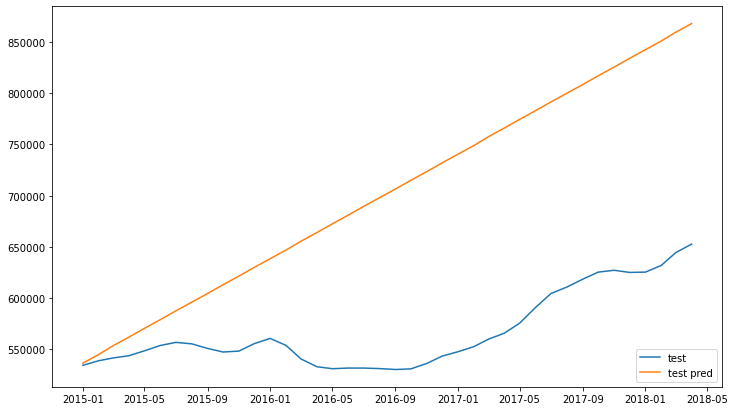

In [39]:
# Predicting on test data 
test_pred = auto_model.predict(start=test.index[0], end=test.index[-1], typ='levels')

fig,ax = plt.subplots(figsize=(12,7))
ax.plot(test, label='test');
ax.plot(test_pred, label='test pred')
ax.legend(loc='lower right');

In [40]:
rmse_arima(train, 0, 2, 1)
aic_arima(train,0,1,1)

12688.446693783115
4432.016156842703


In [41]:
np.sqrt(mean_squared_error(test, test_pred))

153799.31495296195

In [42]:
forecast = auto_model.get_forecast(steps=len(test))
pred_df = forecast_to_df(forecast,ziplist[0])
pred_df.head()

,lower,upper,prediction
2015-01-01,532977.279335,539444.550837,536210.915086
2015-02-01,537394.033156,552049.627188,544721.830172
2015-03-01,540901.492346,565563.998169,553232.745258
2015-04-01,543636.061400,579851.259288,561743.660344
2015-05-01,545688.098186,594821.052672,570254.575429


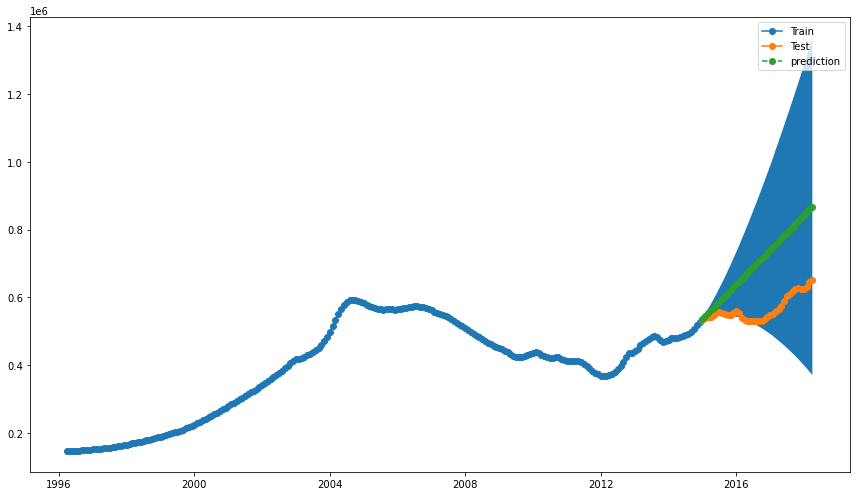

In [43]:
plot_train_test_pred(train,test,pred_df)

plt.show()

This ARIMA model with gridsearch worked pretty well as it was able to predict our test set close. I also like it is upward trending! AIC also went down but RMSE is still very high. Therefore, we will try `auto-arima` on a SARIMA model.

## Model 3: SARIMAX Model

In [44]:
# Running auto_arima
auto_arima(y=train, start_p=0, start_q=0, max_p=10, max_q=10,
                           start_P=0, start_Q=0, max_P=10, max_Q=10, m=12,
                           max_order=None,trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=3944.941, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=3947.874, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=3943.792, Time=0.15 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=3943.351, Time=0.06 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=3943.778, Time=0.18 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=inf, Time=0.45 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=3945.051, Time=0.24 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=3960.481, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=3948.154, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=3962.415, Time=0.12 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=3945.190, Time=0.13 sec

Best model:  ARIMA(0,2,1)(0,0,0)[12]          
Total fit time: 1.505 seconds


ARIMA(order=(0, 2, 1), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [45]:
sarimax_model = SARIMAX(train,
                  order=(0, 2, 1),
                  seasonal_order=(0, 0, 0, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

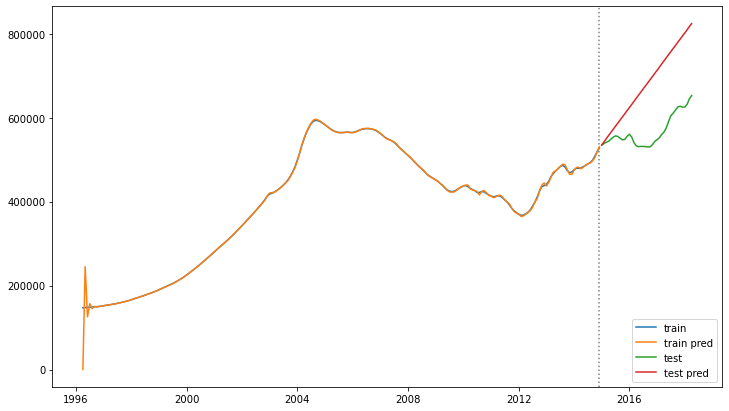

In [46]:
#Plotting training predictions
train_pred = sarimax_model.predict(typ='levels')
test_pred = sarimax_model.predict(start=test.index[0], end=test.index[-1], typ='levels')

fig,ax=plt.subplots(figsize=(12,7))
ax.axvline(train.index[-1], ls=':', color='grey')
ax.plot(train, label='train');
ax.plot(train_pred, label='train pred')
ax.plot(test, label='test')
ax.plot(test_pred, label='test pred')
ax.legend(loc='lower right');

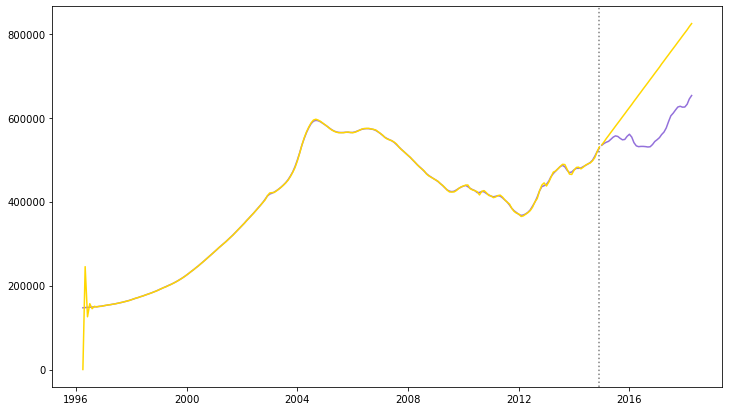

In [47]:
fig,ax=plt.subplots(figsize=(12,7))
ax.axvline(train.index[-1], ls=':', color ='grey')
ax.plot(train, label='train', c='mediumpurple')
ax.plot(train_pred, label='train pred', c='gold')
ax.plot(test, label='test', c='mediumpurple')
ax.plot(test_pred, label='test pred',c='gold');

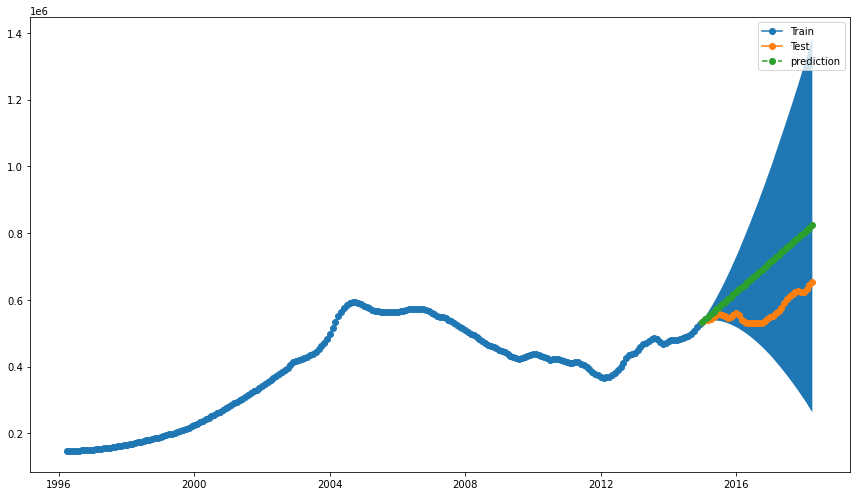

In [48]:
forecast = sarimax_model.get_forecast(steps=len(test))
pred_df = forecast_to_df(forecast,ziplist[0])

plot_train_test_pred(train,test,pred_df)
plt.show()

In [49]:
np.sqrt(mean_squared_error(test, test_pred))

128211.69142048349

Our SARIMAX model performed very well and RMSE on the test data also went down significantly compared to the ARIMAX model. We will run `auto_arima` for the other zipcodes to identify the best performing parameters, and forecast average home values and ROIs for next years below. 

## Forecasting

Let's save each zipcode data into individual dataframe to run the models below.

In [50]:
#ts_92101 = ts_df[ziplist[0]].copy()
ts_91754 = ts_df[ziplist[1]].copy()
ts_92866 = ts_df[ziplist[2]].copy()
ts_92860 = ts_df[ziplist[3]].copy()
ts_96141 = ts_df[ziplist[4]].copy()
ts_95441 = ts_df[ziplist[5]].copy()
ts_93405 = ts_df[ziplist[6]].copy()
ts_95818 = ts_df[ziplist[7]].copy()
ts_93003 = ts_df[ziplist[8]].copy()
ts_94546 = ts_df[ziplist[9]].copy()

### 1. Zipcode 92101: San Diego County - San Diego

In [51]:
gridsearch = auto_arima(y=ts_92101, start_p=0, start_q=0, max_p=10, max_q=10,
                           start_P=0, start_Q=0, max_P=10, max_Q=10, m=12,
                           max_order=None)
gridsearch

ARIMA(order=(5, 1, 1), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)

In [52]:
pdq = (5, 1, 1)
pdqs = (0, 0, 0, 12)
sarimax_model = SARIMAX(ts_92101,order=pdq,
                        seasonal_order=pdqs).fit()


In [53]:
#This function will be used to plot train,test,predicted
def plot_train_test(ts):
    train_size = 0.85
    split_idx = round(len(ts)* train_size)

    # Split
    train = ts.iloc[:split_idx]
    test = ts.iloc[split_idx:]
    
    #Plotting training predictions
    train_pred = sarimax_model.predict(typ='levels')
    test_pred = sarimax_model.predict(start=test.index[0], end=test.index[-1], typ='levels')

    fig,ax=plt.subplots(figsize=(12,7))
    ax.axvline(train.index[-1], ls=':', color='grey')
    ax.plot(train, label='train');
    ax.plot(train_pred, label='train pred')
    ax.plot(test, label='test')
    ax.plot(test_pred, label='test pred')
    ax.legend(loc='lower right');

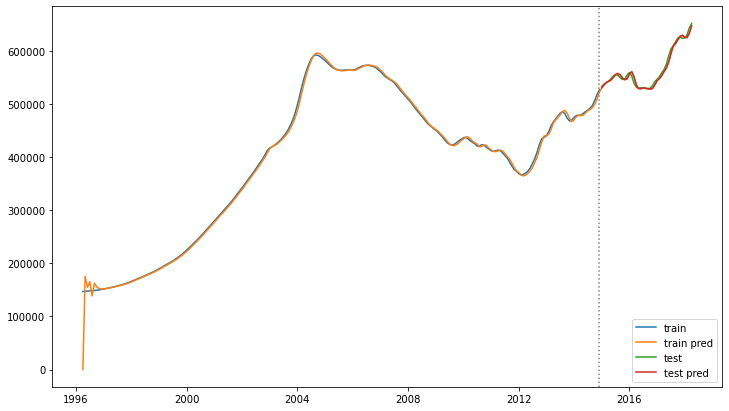

In [54]:
plot_train_test(ts_92101)

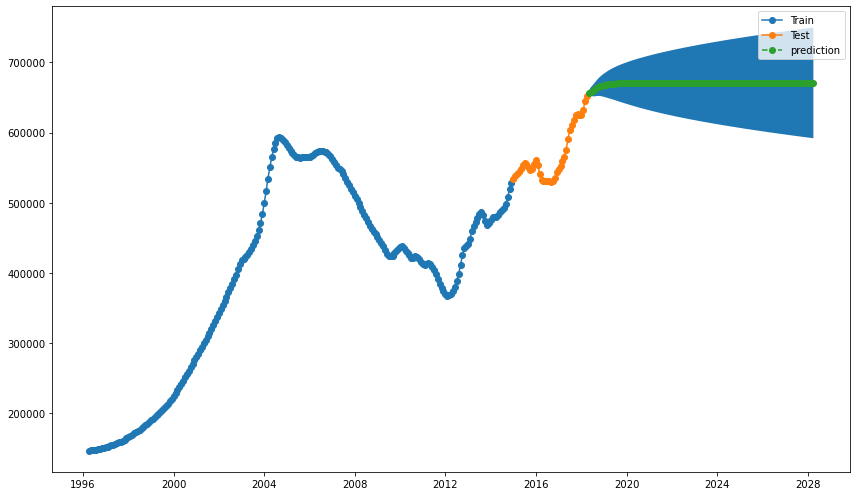

In [55]:
forecast = sarimax_model.get_forecast(steps=120)
pred_df = forecast_to_df(forecast,ziplist[0])

plot_train_test_pred(train,test,pred_df)
plt.show()

In [56]:
#This function will be used to plot ROI for the next 10 years, and print ROI in 1 year, 3 years, 5 years, and 10 years
def calculate_roi(forecast):
    investment = pred_df['prediction'].iloc[0]
    roi = ((pred_df - investment)/investment) * 100
    LowerCI = roi['lower']
    UpperCI = roi['upper']
    roi['prediction'].plot()
    roi_1year = roi['prediction'].iloc[12]
    roi_3year = roi['prediction'].iloc[36]
    roi_5year = roi['prediction'].iloc[60]
    roi_10year = roi['prediction'].iloc[-1]
    print(f'Total Expected ROI in 1 year: {round(roi_1year,2)}%')
    print(f'Total Expected ROI in 3 years: {round(roi_3year,2)}%')
    print(f'Total Expected ROI in 5 years: {round(roi_5year,2)}%')
    print(f'Total Expected ROI in 10 years: {round(roi_10year,2)}%')
    plt.fill_between(roi.index,
                        LowerCI, 
                        UpperCI,color='g',alpha=0.3)
    plt.title('Forecasted ROI for next 10 Years')
    plt.xlabel('Time')
    plt.ylabel('ROI in %')
    plt.tight_layout()

Total Expected ROI in 1 year: 2.02%
Total Expected ROI in 3 years: 2.25%
Total Expected ROI in 5 years: 2.25%
Total Expected ROI in 10 years: 2.25%


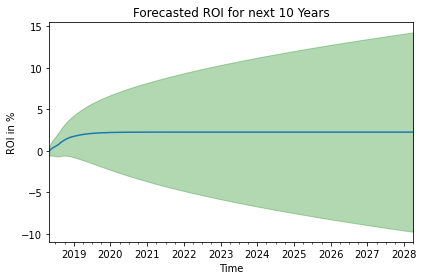

In [57]:
calculate_roi(ts_92101)

### 2. Zipcode 91754: Los Angeles County - Monterey Park

In [58]:
gridsearch = auto_arima(y=ts_91754, start_p=0, start_q=0, max_p=10, max_q=10,
                           start_P=0, start_Q=0, max_P=10, max_Q=10, m=12,
                           max_order=None)
gridsearch

ARIMA(order=(1, 1, 2), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)

In [59]:
pdq = (1, 1, 2)
pdqs = (0, 0, 0, 12)
sarimax_model = SARIMAX(ts_91754,order=pdq,
                        seasonal_order=pdqs).fit()


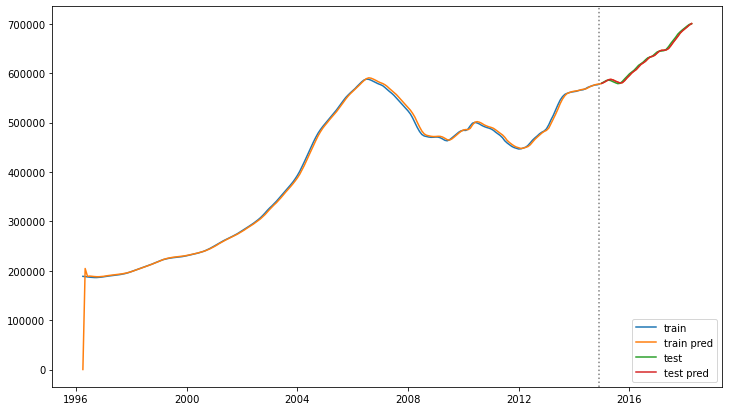

In [60]:
plot_train_test(ts_91754)

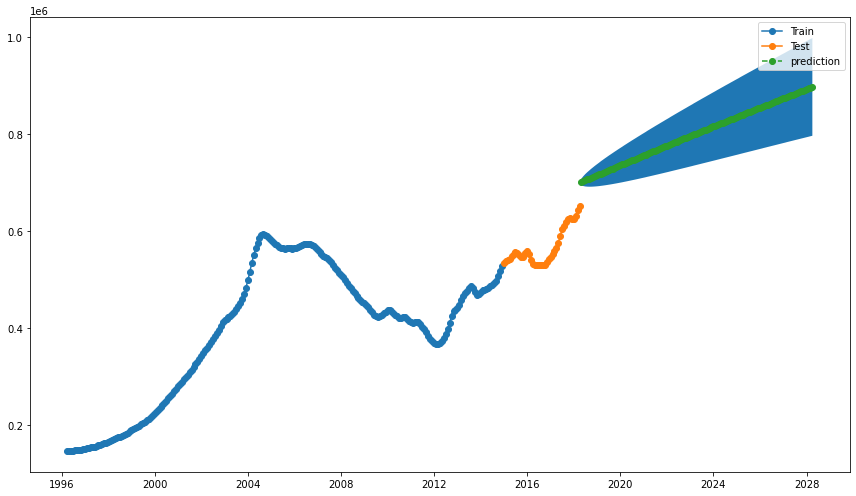

In [61]:
forecast = sarimax_model.get_forecast(steps=120)
pred_df = forecast_to_df(forecast,ziplist[1])

plot_train_test_pred(train,test,pred_df)
plt.show()

Total Expected ROI in 1 year: 2.94%
Total Expected ROI in 3 years: 8.74%
Total Expected ROI in 5 years: 14.42%
Total Expected ROI in 10 years: 27.9%


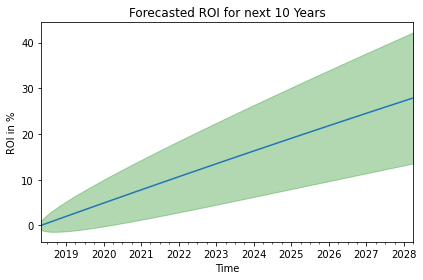

In [62]:
calculate_roi(ts_91754)

### 3. Zipcode 92866: Orange County - Orange

In [63]:
gridsearch = auto_arima(y=ts_92866, start_p=0, start_q=0, max_p=10, max_q=10,
                           start_P=0, start_Q=0, max_P=10, max_Q=10, m=12,
                           max_order=None)
gridsearch

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)

In [64]:
pdq = (1, 1, 1)
pdqs = (0, 0, 0, 12)
sarimax_model = SARIMAX(ts_92866,order=pdq,
                        seasonal_order=pdqs).fit()


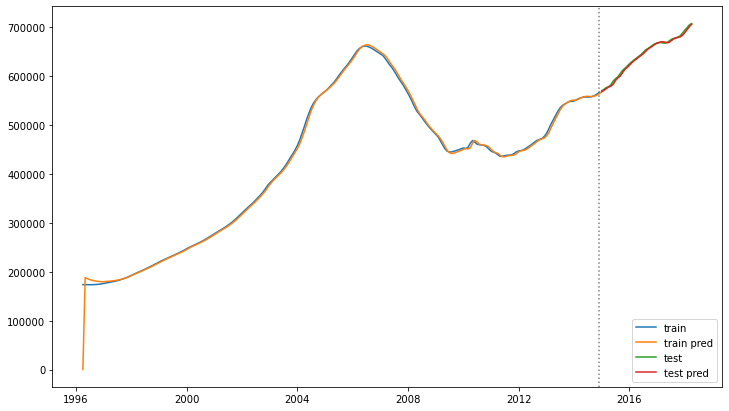

In [65]:
plot_train_test(ts_92866)

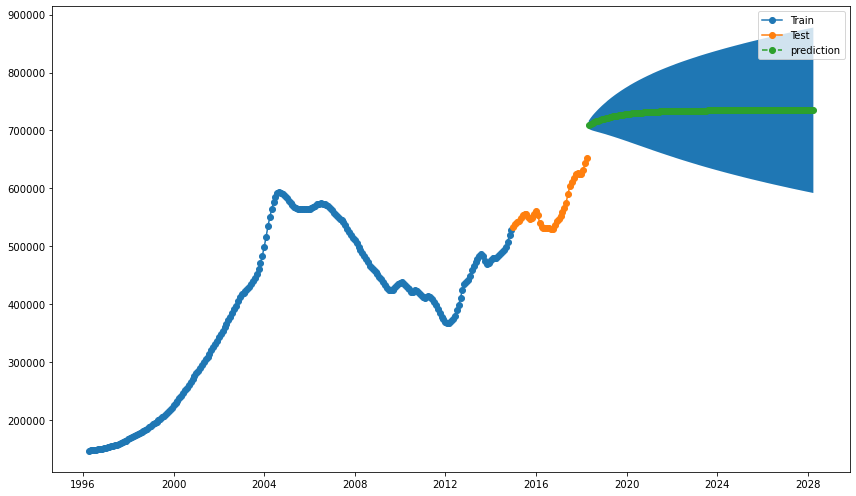

In [66]:
forecast = sarimax_model.get_forecast(steps=120)
pred_df = forecast_to_df(forecast,ziplist[2])

plot_train_test_pred(train,test,pred_df)
plt.show()

Total Expected ROI in 1 year: 1.94%
Total Expected ROI in 3 years: 3.22%
Total Expected ROI in 5 years: 3.48%
Total Expected ROI in 10 years: 3.55%


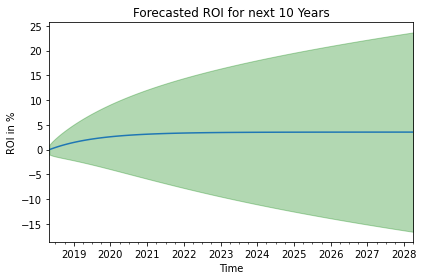

In [67]:
calculate_roi(ts_92866)

### 4. Zipcode 92860: Riverside County - Norco

In [68]:
gridsearch = auto_arima(y=ts_92860, start_p=0, start_q=0, max_p=10, max_q=10,
                           start_P=0, start_Q=0, max_P=10, max_Q=10, m=12,
                           max_order=None)
gridsearch

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [69]:
pdq = (1, 1, 1)
pdqs = (0, 0, 0, 12)
sarimax_model = SARIMAX(ts_92860,order=pdq,
                        seasonal_order=pdqs).fit()


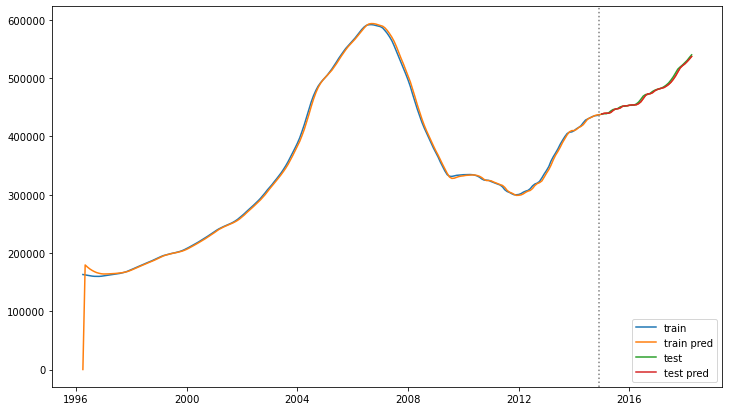

In [70]:
plot_train_test(ts_92860)

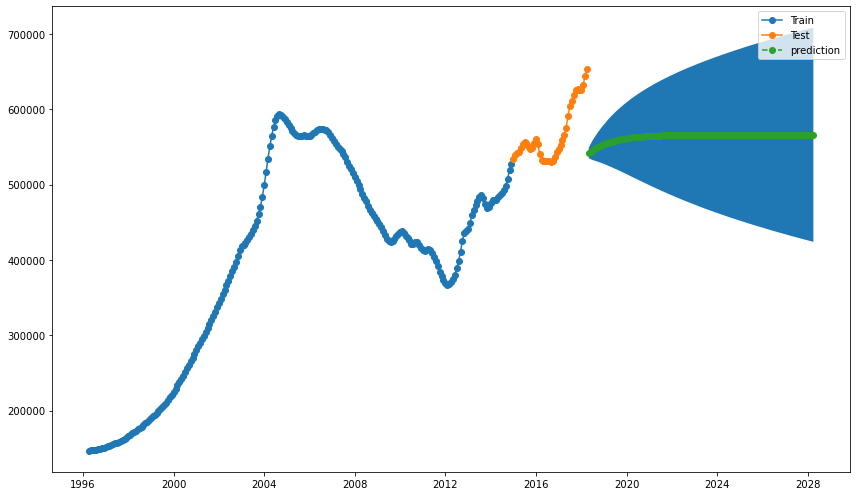

In [71]:
forecast = sarimax_model.get_forecast(steps=120)
pred_df = forecast_to_df(forecast,ziplist[3])

plot_train_test_pred(train,test,pred_df)
plt.show()

Total Expected ROI in 1 year: 2.81%
Total Expected ROI in 3 years: 4.25%
Total Expected ROI in 5 years: 4.45%
Total Expected ROI in 10 years: 4.49%


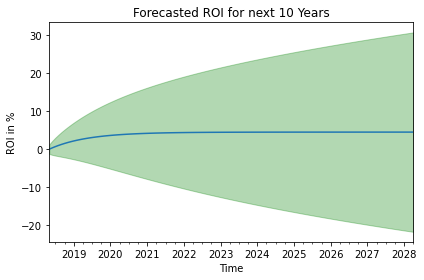

In [72]:
calculate_roi(ts_92860)

### 5. Zipcode 96141: Placer County - Homewood

In [73]:
gridsearch = auto_arima(y=ts_96141, start_p=0, start_q=0, max_p=10, max_q=10,
                           start_P=0, start_Q=0, max_P=10, max_Q=10, m=12,
                           max_order=None)
gridsearch

ARIMA(order=(1, 2, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [74]:
pdq = (1, 2, 0)
pdqs = (0, 0, 0, 12)
sarimax_model = SARIMAX(ts_96141,order=pdq,
                        seasonal_order=pdqs).fit()


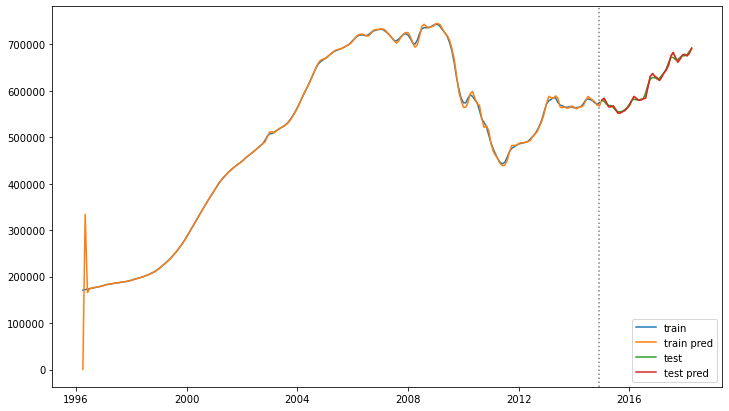

In [75]:
plot_train_test(ts_96141)

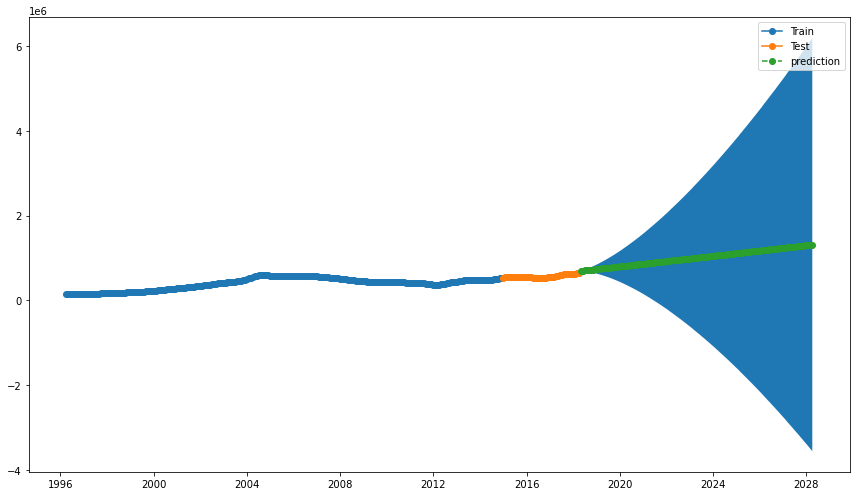

In [76]:
forecast = sarimax_model.get_forecast(steps=120)
pred_df = forecast_to_df(forecast,ziplist[4])

plot_train_test_pred(train,test,pred_df)
plt.show()

Total Expected ROI in 1 year: 9.0%
Total Expected ROI in 3 years: 26.99%
Total Expected ROI in 5 years: 44.99%
Total Expected ROI in 10 years: 89.22%


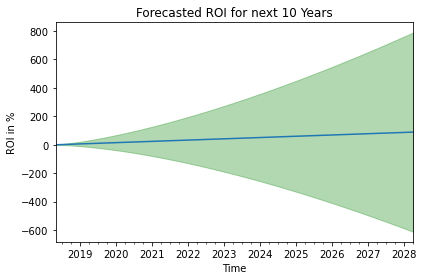

In [77]:
calculate_roi(ts_96141)

### 6. Zipcode 95441 County: Sonoma County - Geyserville

In [78]:
gridsearch = auto_arima(y=ts_95441, start_p=0, start_q=0, max_p=10, max_q=10,
                           start_P=0, start_Q=0, max_P=10, max_Q=10, m=12,
                           max_order=None)
gridsearch

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)

In [79]:
pdq = (1, 1, 1)
pdqs = (0, 0, 0, 12)
sarimax_model = SARIMAX(ts_95441,order=pdq,
                        seasonal_order=pdqs).fit()


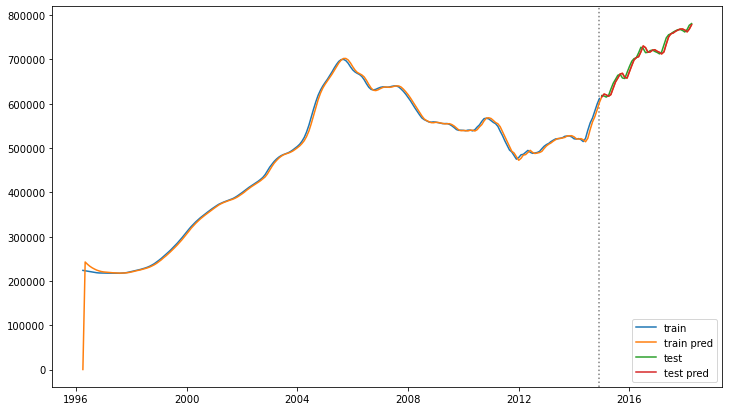

In [80]:
plot_train_test(ts_95441)

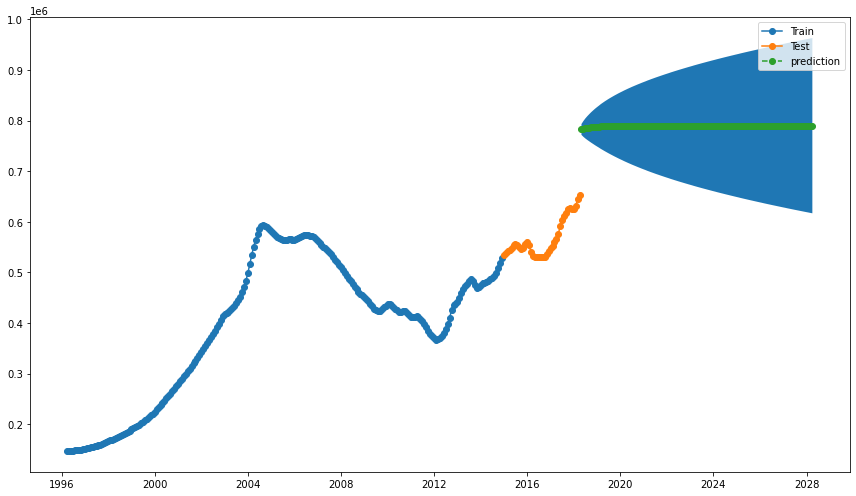

In [81]:
forecast = sarimax_model.get_forecast(steps=120)
pred_df = forecast_to_df(forecast,ziplist[5])

plot_train_test_pred(train,test,pred_df)
plt.show()

Total Expected ROI in 1 year: 0.8%
Total Expected ROI in 3 years: 0.95%
Total Expected ROI in 5 years: 0.95%
Total Expected ROI in 10 years: 0.95%


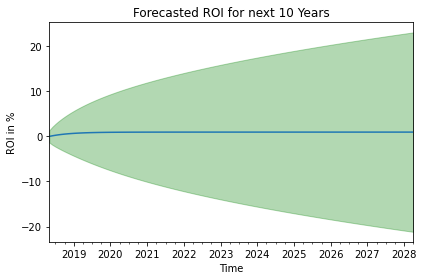

In [82]:
calculate_roi(ts_95441)

### 7. Zipcode 93405: San Luis Obispo County - San Luis Obispo

In [83]:
gridsearch = auto_arima(y=ts_93405, start_p=0, start_q=0, max_p=10, max_q=10,
                           start_P=0, start_Q=0, max_P=10, max_Q=10, m=12,
                           max_order=None)
gridsearch

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)

In [84]:
pdq = (1, 1, 1)
pdqs = (0, 0, 0, 12)
sarimax_model = SARIMAX(ts_93405,order=pdq,
                        seasonal_order=pdqs).fit()


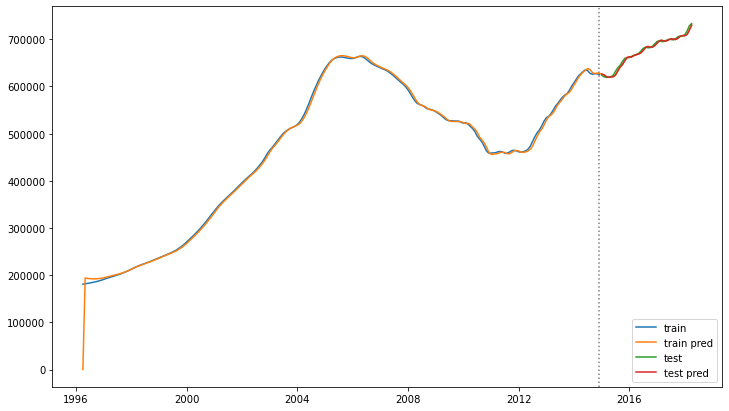

In [85]:
plot_train_test(ts_93405)

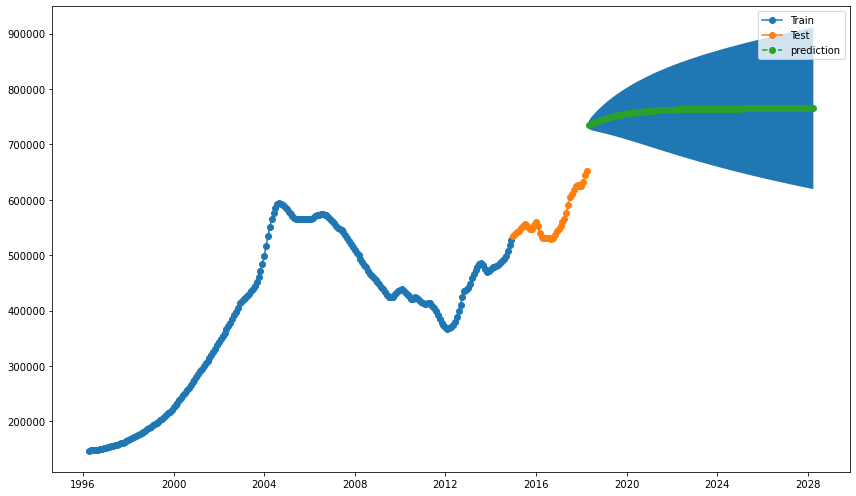

In [86]:
forecast = sarimax_model.get_forecast(steps=120)
pred_df = forecast_to_df(forecast,ziplist[6])

plot_train_test_pred(train,test,pred_df)
plt.show()

Total Expected ROI in 1 year: 2.01%
Total Expected ROI in 3 years: 3.55%
Total Expected ROI in 5 years: 3.95%
Total Expected ROI in 10 years: 4.08%


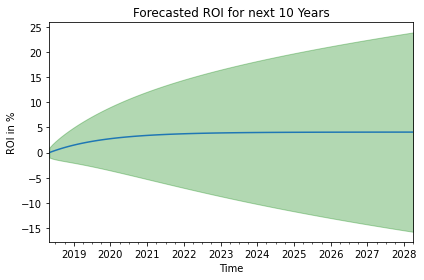

In [87]:
calculate_roi(ts_93405)

### 8. Zipcode 95818: Sacramento County - Sacramento

In [88]:
gridsearch = auto_arima(y=ts_95818, start_p=0, start_q=0, max_p=10, max_q=10,
                           start_P=0, start_Q=0, max_P=10, max_Q=10, m=12,
                           max_order=None)
gridsearch

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)

In [89]:
pdq = (1, 1, 1)
pdqs = (0, 0, 0, 12)
sarimax_model = SARIMAX(ts_95818,order=pdq,
                        seasonal_order=pdqs).fit()


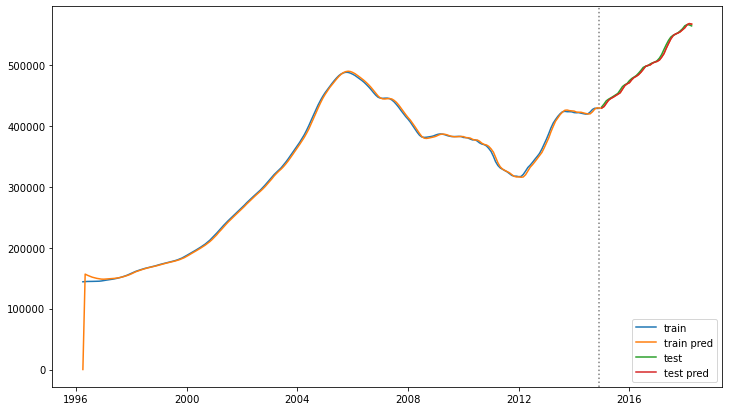

In [90]:
plot_train_test(ts_95818)

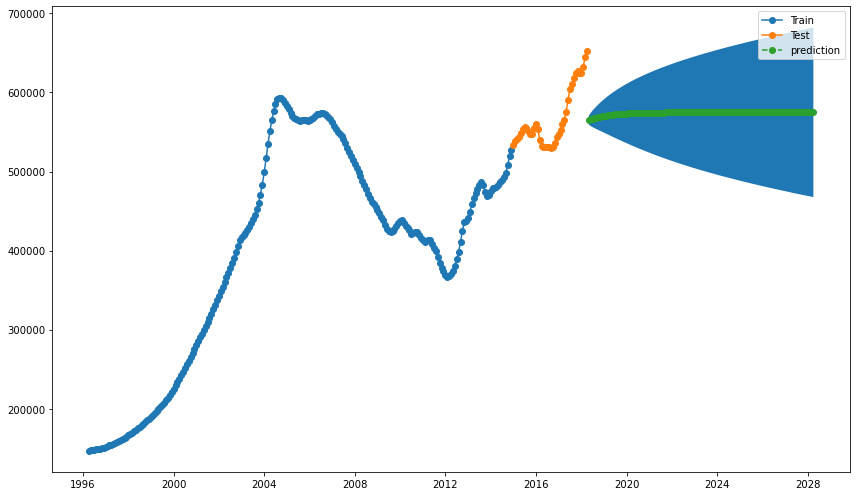

In [91]:
forecast = sarimax_model.get_forecast(steps=120)
pred_df = forecast_to_df(forecast,ziplist[7])

plot_train_test_pred(train,test,pred_df)
plt.show()

Total Expected ROI in 1 year: 1.2%
Total Expected ROI in 3 years: 1.7%
Total Expected ROI in 5 years: 1.76%
Total Expected ROI in 10 years: 1.76%


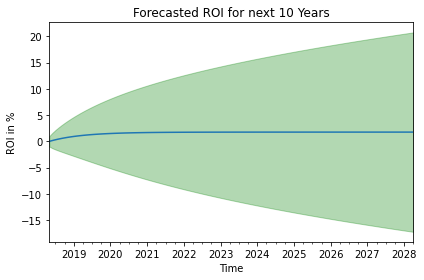

In [92]:
calculate_roi(ts_95818)

### 9. Zipcode 93003: Ventura County - Ventura

In [93]:
gridsearch = auto_arima(y=ts_93003, start_p=0, start_q=0, max_p=10, max_q=10,
                           start_P=0, start_Q=0, max_P=10, max_Q=10, m=12,
                           max_order=None)
gridsearch

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)

In [94]:
pdq = (1, 1, 1)
pdqs = (0, 0, 0, 12)
sarimax_model = SARIMAX(ts_93003,order=pdq,
                        seasonal_order=pdqs).fit()


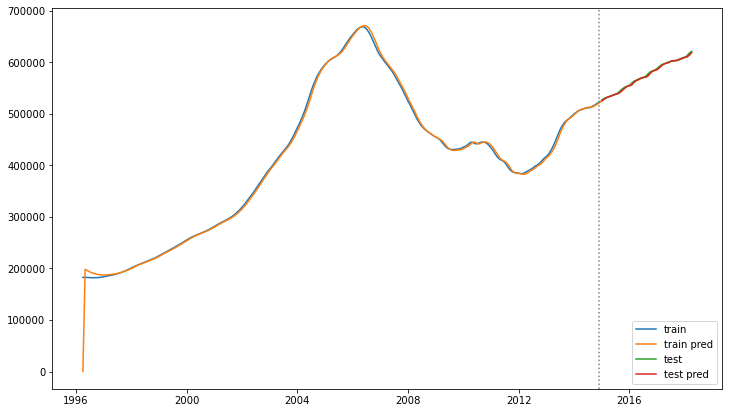

In [95]:
plot_train_test(ts_93003)

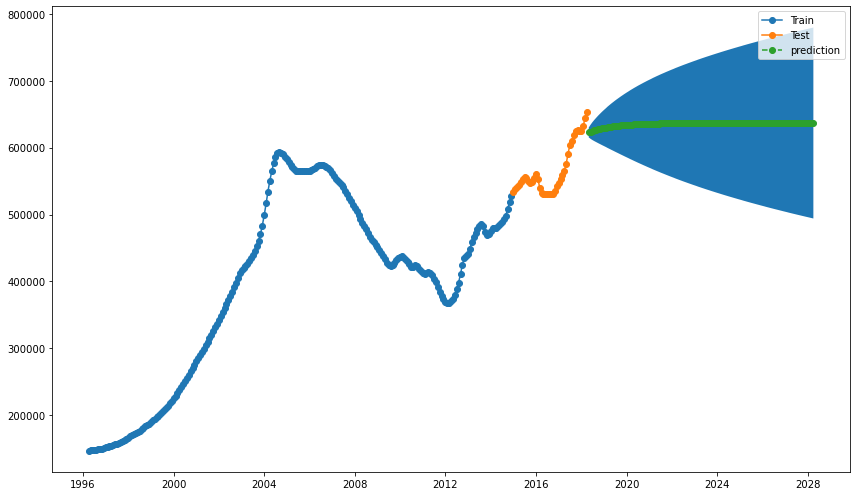

In [96]:
forecast = sarimax_model.get_forecast(steps=120)
pred_df = forecast_to_df(forecast,ziplist[8])

plot_train_test_pred(train,test,pred_df)
plt.show()

Total Expected ROI in 1 year: 1.4%
Total Expected ROI in 3 years: 2.14%
Total Expected ROI in 5 years: 2.25%
Total Expected ROI in 10 years: 2.27%


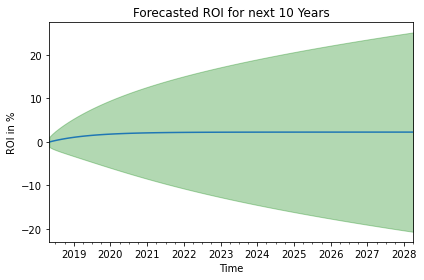

In [97]:
calculate_roi(ts_93003)

### 10. Zipcode 94546: Alamenda County - Castro Valley

In [98]:
gridsearch = auto_arima(y=ts_94546, start_p=0, start_q=0, max_p=10, max_q=10,
                           start_P=0, start_Q=0, max_P=10, max_Q=10, m=12,
                           max_order=None)
gridsearch

ARIMA(order=(1, 1, 2), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)

In [99]:
pdq = (1, 1, 2)
pdqs = (0, 0, 0, 12)
sarimax_model = SARIMAX(ts_94546,order=pdq,
                        seasonal_order=pdqs).fit()


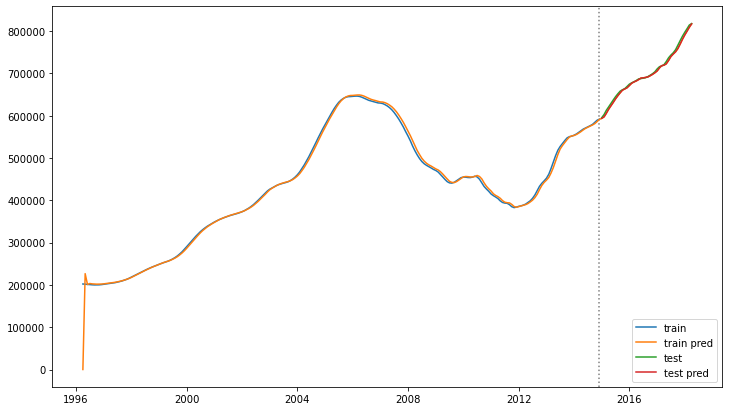

In [100]:
plot_train_test(ts_94546)

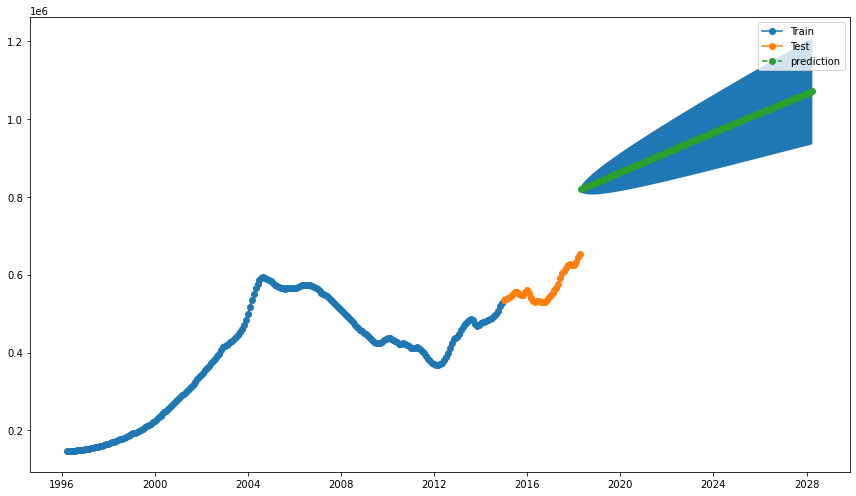

In [101]:
forecast = sarimax_model.get_forecast(steps=120)
pred_df = forecast_to_df(forecast,ziplist[9])

plot_train_test_pred(train,test,pred_df)
plt.show()

Total Expected ROI in 1 year: 3.19%
Total Expected ROI in 3 years: 9.5%
Total Expected ROI in 5 years: 15.72%
Total Expected ROI in 10 years: 30.62%


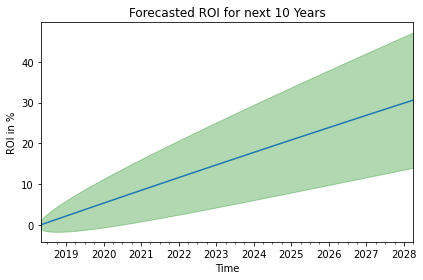

In [102]:
calculate_roi(ts_94546)

## Conclusion & Recommendation
Our result shows that below 5 zipcodes have the highest ROI, and therefore, I recommend investing in properties in below zip codes. 

**Zip code 91754 (Monterey Park):** Buy and hold for at least 10 years or more.


                                   Total expected return in 1 year: 2.94%
                                   Total expected return in 3 years: 8.74%
                                   Total expected return in 5 years: 14.42%
                                   Total expected return in 10 years: 27.9 %
                                  
                                
**Zip code 92860 (Norco):** Buy and hold for at least 3 years.

                                   Total expected return in 1 year: 2.81%
                                   Total expected return in 3 years: 4.25%
                                   Total expected return in 5 years: 4.45%
                                   Total expected return in 10 years: 4.49% 
                                  
                                  
**Zip code 96141 (Homewood):** Buy and hold for at least 10 years or more.

                                   Total expected return in 1 year: 9.06%
                                   Total expected return in 3 years: 26.99%
                                   Total expected return in 5 years: 44.99%
                                   Total expected return in 10 years: 89.22%
                            
**Zip code 93405 (San Luis Obispo):** Buy and hold for at least 3-5 years.

                                   Total expected return in 1 year: 2.01%
                                   Total expected return in 3 years: 3.55%
                                   Total expected return in 5 years: 3.95%
                                   Total expected return in 10 years 4.08%

**Zip code 94546 (Castro Valley):** Buy and hold for at least 10 years or more.

                                   Total expected return in 1 year: 3.19%
                                   Total expected return in 3 years: 9.5%
                                   Total expected return in 5 years: 15.72%
                                   Total expected return in 10 years: 30.62%

       

In [103]:
import folium

# Make an empty map
map = folium.Map(location=[36,-120], tiles="OpenStreetMap", zoom_start=6)

# Show the map
map

# Make a data frame with dots to show on the map
data = pd.DataFrame({
   'lon':[-118.1415, -117.5378, -120.1762, -120.6890, -122.0781],
   'lat':[39.1308, 33.9226, 39.0783, 35.2994, 37.7189],
   'name':['Monterey Park', 'Norco', 'Homewood', ' San Luis Obispo', 'Castro Valley'],
}, dtype=str)

data

,lon,lat,name
0,-118.1415,39.1308,Monterey Park
1,-117.5378,33.9226,Norco
2,-120.1762,39.0783,Homewood
3,-120.689,35.2994,San Luis Obispo
4,-122.0781,37.7189,Castro Valley


In [104]:
for i in range(0,len(data)):
    folium.Marker(location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
     popup=folium.Popup(data.iloc[i]['name'], show=True),
   ).add_to(map)
    
map

## Next Steps:
1. This project was purely based on using past average home values to make predictions for the next 10 years. The analysis can be more meaningful if we could take other contributing factors for a home value, such as population, tax rate, and school ranking into consideration.

2. We can potentially add more recent data to increase the effectiveness of the model. It would be interesting to examine if any recent events like COVID-19 have affected the real estate market.